# Traffic Sign Classifier

In [119]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import RepeatVector
from keras.models import Model

import random

import cv2

import requests
from PIL import Image

## Contents of this notebook

* [Step 0: Load the Data](#Step-0:-Load-the-Data)
* [Step 1: Dataset Summary and Exploration](#Step-1:-Dataset-Summary-and-Exploration)
* [Step 2: Design and Test the Model Architecture](#Step-2:-Design-and-Test-the-Model-Architecture)
* [Step 3: Test the Model on New Images](#Step-3:-Test-the-Model-on-New-Images)
* [Visualizing the CNN model](#Visualizing-the-CNN-model)
* [Visualizing intermediate activations](#Visualizing-intermediate-activations)
* [Visualizing every channel in every intermediate activation](#Visualizing-every-channel-in-every-intermediate-activation)
* [References](#References)

# Step 0: Load the Data

In [120]:
!ls 'data/traffic-signs-data'

signnames.csv test.p        train.p       valid.p


In [121]:
datadir = 'data/traffic-signs-data'

In [122]:
training_pickle = datadir + '/' + 'train.p'
validation_pickle = datadir + '/' + 'valid.p'
test_pickle = datadir + '/' + 'test.p'

In [123]:
with open(training_pickle, 'rb') as f:
    train_data = pickle.load(f)
with open(test_pickle, 'rb') as f:
    test_data = pickle.load(f)
with open(validation_pickle, 'rb') as f:
    validation_data = pickle.load(f)
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = validation_data['features'], validation_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Step 1: Dataset Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

## Basic summary of the data

In [124]:
# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = X_val.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


We can also just print the shape of each data set:

In [125]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


For example, our training dataset has shape (34799, 32, 32, 3). This means:
* We have 34799 images in our training set
* Each image has dimensions of 32x32 pixels
* Each image has a depth of 3 - the signs are in RGB format, so one channel for each colour


Run some tests to validate the data is imported as expected.

In [126]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images must equal the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images must equal the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images must equal the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are expected to be 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are expected to be 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are expected to be 32 x 32 x 3"

## Exploratory visualization of the dataset

In [127]:
data = pd.read_csv(datadir+ '/' +'signnames.csv')

In [128]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


Let's look at some sample images from each class.

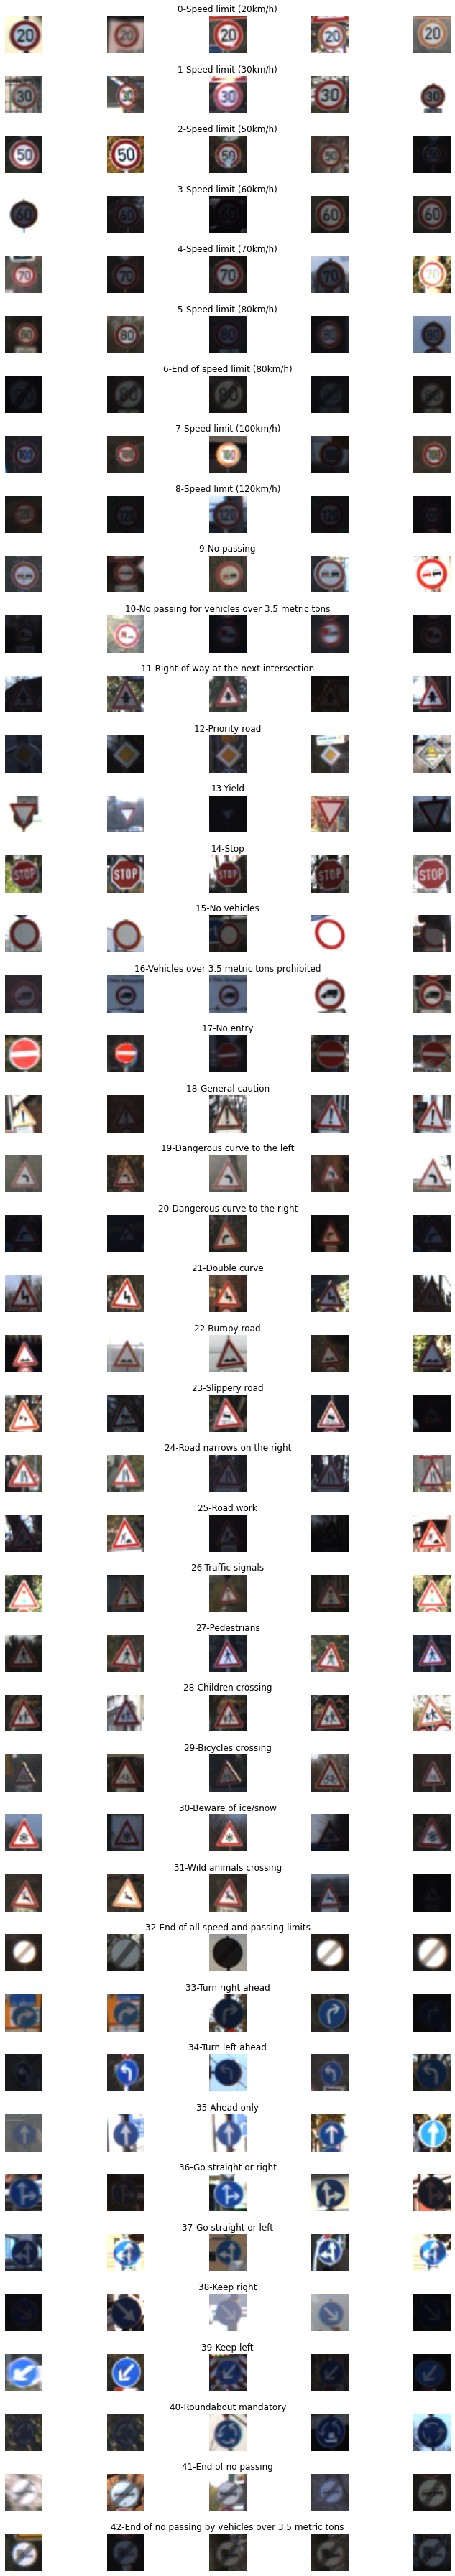

In [129]:
num_of_samples=[]
 
cols = 5
 
fig, axs = plt.subplots(nrows=n_classes, ncols=cols, figsize=(10,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

In [130]:
print(num_of_samples)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Next, I will create a histogram to show the distribution of the training data.

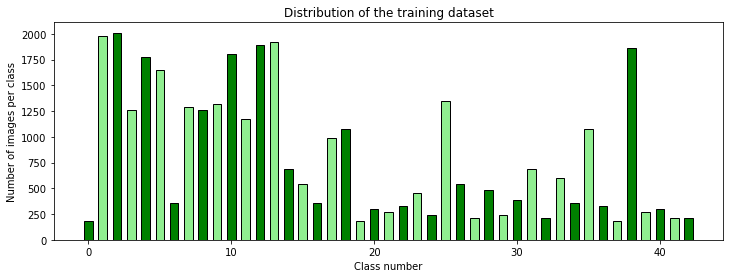

Min number of images per class: 180
Max number of images per class: 2010


In [131]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples, width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images per class")
plt.show()

print("Min number of images per class: {}".format(min(num_of_samples)))
print("Max number of images per class: {}".format(max(num_of_samples)))

# Step 2: Design and Test the Model Architecture
The goal here is to design and implement a deep learning model that learns to recognize traffic signs. We will train and test our model on the [German Traffic Sign Dataset](#References).

We will use the LeNet-5 CNN implementation as a starting point.  

To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others)
- Generate synthetic data


## Preprocess the Data Set (normalization, grayscale, etc.)

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into our CNN. Currently, our data sits in the file system as JPEG files, so the steps for getting it into the network are roughly as follows ([Chollet, 2018](#References)):

  1. Read the picture files.
  2. Decode the JPEG content to RGB grids of pixels.
  3. Convert these into floating-point tensors.
  4. Rescale the pixel values (between 0 and 255) to the interval `[0, 1]` (because we know neural networks prefer to deal with small input values).


At a minimum, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. 

(32, 32, 3)
36


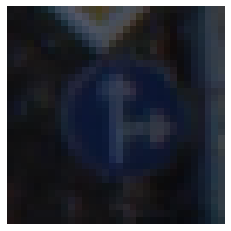

In [132]:
image_index = 1000
plt.imshow(X_train[image_index])
plt.axis('off')
print(X_train[image_index].shape)
print(y_train[image_index])

As we can see from the output earlier, the label `36` corresponds to the _"Go straight or right"_ category. This is correct for the image at index 1000.

### Convert our image to greyscale
When analyzing traffic signs, colour is not a significant factor. Therefore we can convert our images to greyscale and make processing more efficient.

In [133]:
def greyscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [134]:
def plot_greyscale_image(image):
    '''
    Gray scale images, i.e. images with only one colorchannel, are interpreted by imshow to be 
    plotted using a colormap. You therefore need to specify the colormap you want to use 
    (and the normalization, if it matters). 
    
    https://stackoverflow.com/questions/43157949/opencv-convert-to-grayscale-not-working-properly
    '''
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [135]:
original_image = X_train[1000]
greyscale_image = greyscale(original_image)

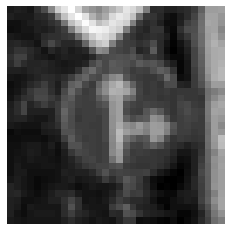

(32, 32)


In [136]:
plot_greyscale_image(greyscale_image)    
print(greyscale_image.shape)

### Histogram Equalisation
Aims to standardise the brightness in all our images. Only accepts greyscale images, because it does not have a depth.

In [137]:
def equalize(image):
    image = cv2.equalizeHist(image)
    return image

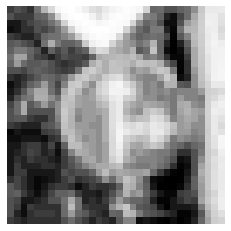

(32, 32)


In [138]:
equalized_image = equalize(greyscale_image)

plot_greyscale_image(equalized_image)

print(equalized_image.shape)


### Apply these techniques to all our images

In [139]:
def preprocessing(image):
    image = greyscale(image)
    image = equalize(image)
    
    #normalize the image so all values are normalized between 0 and 1
    image  = image/255
    
    return image

In [140]:
# Preprocess the training dataset
# Each element from the array will go into the function as a parameter. The map function returns a list.
X_train_preprocessed = np.array(list(map(preprocessing, X_train))) 

# Preprocess the validation dataset
X_val_preprocessed = np.array(list(map(preprocessing, X_val)))

# Preprocess the test dataset
X_test_preprocessed = np.array(list(map(preprocessing, X_test)))


Let's look at the preprocessing applied to a random image from our training dataset:

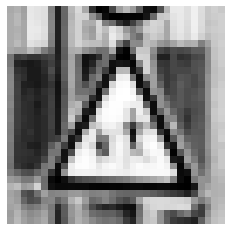

In [141]:
random_image = X_train_preprocessed[random.randint(0, len(X_train_preprocessed)-1)]

plot_greyscale_image(random_image)

Verify that our pre-prcessed dataset is the same shape as our original dataset:

In [142]:
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)
print(X_val_preprocessed.shape)

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


This shows the `X_train_preprocessed` array as a shape of `(34799, 32, 32)`, i.e., 34,799 images. Each image is size 32x32. The next step in preparing our data for use in a CNN is to add depth to our data. At the moment, each image is 2D, and does not have a depth. CNNs work by applying a filter to the image being viewed. In the case of greyscale images, there is one channel present, therefore our data must reflect the presence of this depth. And so, by adding this depth, our data will be in the desired shape to be used as an input to the convolutional layer.

In [143]:
X_train_preprocessed = X_train_preprocessed.reshape(34799, 32, 32, 1)
X_test_preprocessed = X_test_preprocessed.reshape(12630, 32, 32, 1)
X_val_preprocessed = X_val_preprocessed.reshape(4410, 32, 32, 1)

The `ImageDataGenerator` class lets us quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors ([Chollet, 2018](#References)). 

In [144]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1, #10% of the image width
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10
                            )


test_datagen = ImageDataGenerator(width_shift_range=0.1, #10% of the image width
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10
                            )


val_datagen = ImageDataGenerator(width_shift_range=0.1, #10% of the image width
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10
                            )

# compute quantities required for featurewise normalization
train_datagen.fit(X_train_preprocessed)
test_datagen.fit(X_test_preprocessed)
val_datagen.fit(X_val_preprocessed)


In [145]:
batch_size = 20

In [146]:
# An iterator that stores a batch of 20 images, with their labels
batches = train_datagen.flow(X_train_preprocessed, y_train, batch_size=batch_size)

In [147]:
X_batch, y_batch = next(batches)

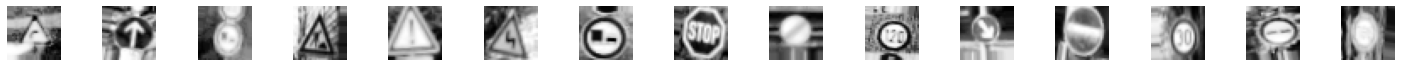

In [148]:
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
    axs[i].axis('off')

In [149]:
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)
print(X_val_preprocessed.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


The final step in preparing our data for use with the CNN is to one-hot-encode our data.  

In [150]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
y_val = to_categorical(y_val, n_classes)

We have now successfully pre-processed our data, and are now ready to use our data to train and validate our CNN.

## Designing our CNN

Figure 2 from the paper by LeCun, et al (1998) shows the architecture of the CNN model we are going to build:
![LeNet-5 CNN Architecture](./Images/LeNet-5-CNN-Architecture.png)

This describes the architecture used for classifying hand-writren digits. We will be designing a model for classifying traffic signs, but the basic architecture is the same.


## Model Architecture

In [151]:
# hyperparameters - adjust these to obtain optimal performance
num_filters = 60 # more filters requires more computing power
filter_size = (5, 5) # set the size of our fitler to N x M
image_shape = (32,32,1)
pool_size = (2,2)
activation_function = 'relu'
hidden_layer_nodes = 500 # lower number is less accurate; higher number requires more computing power
dropout_rate = 0.5

In [152]:
def leNet_traffic_sign_classifier_model():
    model = Sequential(name="LeNet_Traffic_Sign_Classifier")

    # we are creating a 2D NN
    model.add(Conv2D(num_filters, filter_size, input_shape=image_shape, activation=activation_function, name='layer_1_conv2d')) 
    model.add(Conv2D(num_filters, filter_size, activation=activation_function, name='layer_2_conv2d_2')) 
    model.add(MaxPooling2D(pool_size=pool_size, name='layer_3_pooling_layer_1')) # pooling scales down the image to half its size
    
    model.add(Conv2D(30, (3,3), activation=activation_function, name='layer_4_conv2d_3'))
    model.add(Conv2D(30, (3,3), activation=activation_function, name='layer_5_conv2d_4'))
    model.add(MaxPooling2D(pool_size=pool_size, name='layer_6_pooling_layer_2'))
    #model.add(Dropout(dropout_rate))
    
    # flatten our data so it can be fed in
    model.add(Flatten(name='layer_7_flatten'))
    model.add(Dense(hidden_layer_nodes, activation=activation_function, name='layer_8_dense_1'))
    model.add(Dropout(dropout_rate, name='layer_9_dropout_1'))
    model.add(Dense(n_classes, activation='softmax', name='layer_10_dense_2'))
    
    # Complie the model
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Train, Validate, and Test the Model

In [153]:
RETRAIN_MODEL = False
path_to_model = 'models/traffic_sign_classifier'
history_pickle = 'models/traffic_classifier_history.p'

if RETRAIN_MODEL:
    print("(Re)training model")
    model = leNet_traffic_sign_classifier_model()
    
    steps_per_epoch = len(X_train)//batch_size
    validation_steps = len(X_val)//batch_size 
    
    train_generator = train_datagen.flow(X_train_preprocessed, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val_preprocessed, y_val, batch_size=8)

    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch, 
                        epochs=12,
                        validation_data=val_generator,
                        validation_steps=validation_steps) 
    # Save the model
    model.save(path_to_model)

    # Save the history to a pickle file
    with open(history_pickle, 'wb') as history_file:
        pickle.dump(history.history, history_file)

else:
    print("Loading model from file", path_to_model)
    model = keras.models.load_model(path_to_model)
    
    
    history = keras.callbacks.History()
    print("Loading history from pickle", history_pickle)
    history.history = pickle.load(open(history_pickle, 'rb'))

print(model.summary())   

(Re)training model
Epoch 1/12
1739/1739 [==============================] - 96s 54ms/step - loss: 2.3395 - accuracy: 0.3555 - val_loss: 0.4813 - val_accuracy: 0.8557
Epoch 2/12
1739/1739 [==============================] - 99s 57ms/step - loss: 0.5155 - accuracy: 0.8434 - val_loss: 0.3063 - val_accuracy: 0.9017
Epoch 3/12
1739/1739 [==============================] - 103s 59ms/step - loss: 0.3226 - accuracy: 0.9015 - val_loss: 0.2221 - val_accuracy: 0.9381
Epoch 4/12
1739/1739 [==============================] - 98s 56ms/step - loss: 0.2423 - accuracy: 0.9240 - val_loss: 0.1789 - val_accuracy: 0.9415
Epoch 5/12
1739/1739 [==============================] - 99s 57ms/step - loss: 0.1931 - accuracy: 0.9381 - val_loss: 0.1415 - val_accuracy: 0.9545
Epoch 6/12
1739/1739 [==============================] - 99s 57ms/step - loss: 0.1835 - accuracy: 0.9437 - val_loss: 0.1453 - val_accuracy: 0.9540
Epoch 7/12
1739/1739 [==============================] - 101s 58ms/step - loss: 0.1637 - accuracy: 0.9498

Here is a sample output from training the model:

```sh
(Re)training model
Epoch 1/10
1739/1739 [==============================] - 77s 39ms/step - loss: 2.3621 - accuracy: 0.3520 - val_loss: 0.5487 - val_accuracy: 0.8364
Epoch 2/10
1739/1739 [==============================] - 83s 47ms/step - loss: 0.5400 - accuracy: 0.8361 - val_loss: 0.3272 - val_accuracy: 0.9040
Epoch 3/10
1739/1739 [==============================] - 90s 52ms/step - loss: 0.3327 - accuracy: 0.8980 - val_loss: 0.2621 - val_accuracy: 0.9256
Epoch 4/10
1739/1739 [==============================] - 99s 57ms/step - loss: 0.2556 - accuracy: 0.9219 - val_loss: 0.1723 - val_accuracy: 0.9545
Epoch 5/10
1739/1739 [==============================] - 94s 54ms/step - loss: 0.1941 - accuracy: 0.9410 - val_loss: 0.1658 - val_accuracy: 0.9557
Epoch 6/10
1739/1739 [==============================] - 95s 55ms/step - loss: 0.1674 - accuracy: 0.9479 - val_loss: 0.1309 - val_accuracy: 0.9608
Epoch 7/10
1739/1739 [==============================] - 90s 52ms/step - loss: 0.1533 - accuracy: 0.9537 - val_loss: 0.1441 - val_accuracy: 0.9625
Epoch 8/10
1739/1739 [==============================] - 97s 56ms/step - loss: 0.1394 - accuracy: 0.9579 - val_loss: 0.1416 - val_accuracy: 0.9534
Epoch 9/10
1739/1739 [==============================] - 97s 56ms/step - loss: 0.1361 - accuracy: 0.9585 - val_loss: 0.0957 - val_accuracy: 0.9705
Epoch 10/10
1739/1739 [==============================] - 90s 52ms/step - loss: 0.1228 - accuracy: 0.9616 - val_loss: 0.1073 - val_accuracy: 0.9727
INFO:tensorflow:Assets written to: models/traffic_sign_classifier/assets
Model: "LeNet_Traffic_Sign_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
layer_1_conv2d (Conv2D)      (None, 28, 28, 60)        1560      
_________________________________________________________________
layer_2_conv2d_2 (Conv2D)    (None, 24, 24, 60)        90060     
_________________________________________________________________
layer_3_pooling_layer_1 (Max (None, 12, 12, 60)        0         
_________________________________________________________________
layer_4_conv2d_3 (Conv2D)    (None, 10, 10, 30)        16230     
_________________________________________________________________
layer_5_conv2d_4 (Conv2D)    (None, 8, 8, 30)          8130      
_________________________________________________________________
layer_6_pooling_layer_2 (Max (None, 4, 4, 30)          0         
_________________________________________________________________
layer_7_flatten (Flatten)    (None, 480)               0         
_________________________________________________________________
layer_8_dense_1 (Dense)      (None, 500)               240500    
_________________________________________________________________
layer_9_dropout_1 (Dropout)  (None, 500)               0         
_________________________________________________________________
layer_10_dense_2 (Dense)     (None, 43)                21543     
=================================================================
Total params: 378,023
Trainable params: 378,023
Non-trainable params: 0
_________________________________________________________________
None
```

### Model accuracy

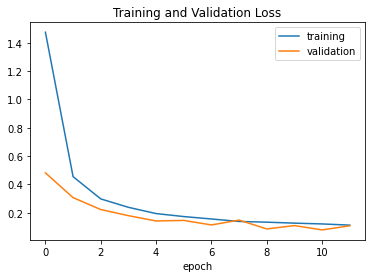

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

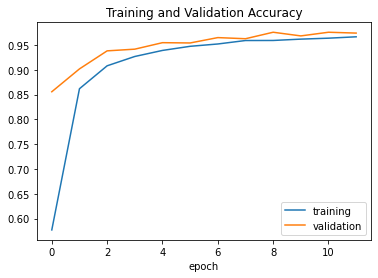

In [155]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

In [156]:
score = model.evaluate(X_test_preprocessed, y_test, verbose=0)

In [157]:
print("Test Score {:.2}".format(score[0]))
print("Test Accuracy {:.2%}".format(score[1]))

Test Score 0.11
Test Accuracy 97.43%


Test **accuracy more than 97%**, with loss approaching 0 (but still not 0) for training and validation. This means there is still some possibility that our model will incorrectly classify some data it has not seen during training and validation.

# Step 3: Test the Model on New Images

To give us insight into how well our model works we will try a variety of unseen images of German traffic signs to see if our model handles them correctly.


### Utility functions
These are some utility functions to help with preprocessing and image layout.

In [158]:
def preprocess_img(img):
    """
    A utility function to pre-process the an image file
    """
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    
    return img

In [159]:
 def plot_5_images_side_by_side_cmap(img_1, img_1_title,
                                        img_2, img_2_title,
                                        img_3, img_3_title,
                                        img_4, img_4_title,
                                        img_5, img_5_title,
                                        cmap_img_1='gray',
                                        cmap_img_2='gray',
                                        cmap_img_3='gray',
                                        cmap_img_4='gray',
                                        cmap_img_5='gray'
                                        ):
        """
        A utility function to print 5 images side-by-side.
        """

        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 10))
        f.tight_layout()
        font_size = 18

        ax1.set_title(img_1_title, fontsize=font_size)
        ax1.imshow(img_1, cmap=cmap_img_1)

        ax2.set_title(img_2_title, fontsize=font_size)
        ax2.imshow(img_2, cmap=cmap_img_2)

        ax3.set_title(img_3_title, fontsize=font_size)
        ax3.imshow(img_3, cmap=cmap_img_3)

        ax4.set_title(img_4_title, fontsize=font_size)
        ax4.imshow(img_4, cmap=cmap_img_4)

        ax5.set_title(img_5_title, fontsize=font_size)
        ax5.imshow(img_5, cmap=cmap_img_5)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Load and Output the Images

In [160]:
import glob

traffic_sign_files = glob.glob('./data/traffic-signs-test-images/*.jpg')
print(traffic_sign_files)

['./data/traffic-signs-test-images/test5.jpg', './data/traffic-signs-test-images/test4.jpg', './data/traffic-signs-test-images/test1.jpg', './data/traffic-signs-test-images/test3.jpg', './data/traffic-signs-test-images/test2.jpg']


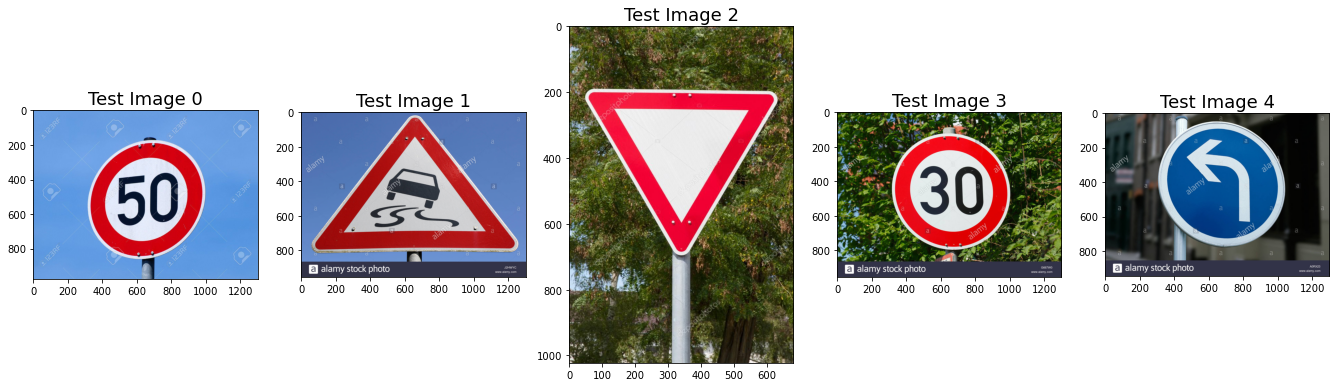

In [161]:
plot_5_images_side_by_side_cmap(
    mpimg.imread(traffic_sign_files[0]), "Test Image 0",
    mpimg.imread(traffic_sign_files[1]), "Test Image 1",
    mpimg.imread(traffic_sign_files[2]), "Test Image 2",
    mpimg.imread(traffic_sign_files[3]), "Test Image 3",
    mpimg.imread(traffic_sign_files[4]), "Test Image 4"
)

Here is what these images look like after pre-processing:

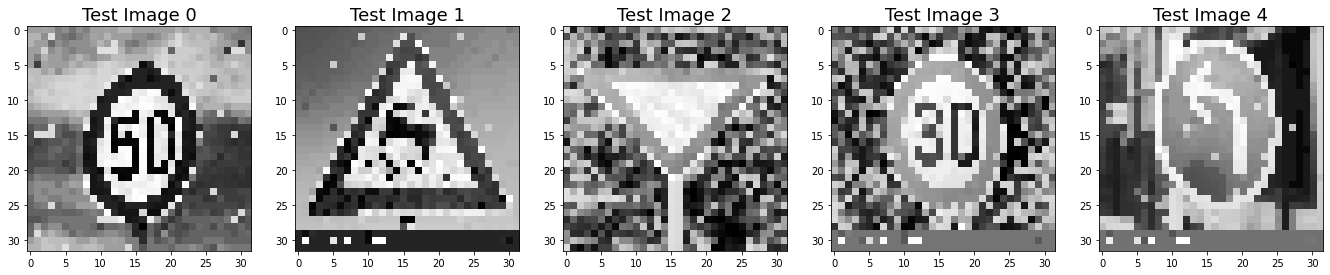

In [162]:
plot_5_images_side_by_side_cmap(
    preprocess_img(cv2.imread(traffic_sign_files[0])), "Test Image 0",
    preprocess_img(cv2.imread(traffic_sign_files[1])), "Test Image 1",
    preprocess_img(cv2.imread(traffic_sign_files[2])), "Test Image 2",
    preprocess_img(cv2.imread(traffic_sign_files[3])), "Test Image 3",
    preprocess_img(cv2.imread(traffic_sign_files[4])), "Test Image 4"
)

### Predict the Sign Type for Each Image
Run the predictions here and use the model to output the prediction for each image. Note we pre-process the images with the same pre-processing pipeline used earlier.

In [163]:
def get_label_for_class(id):
    """
    Return the class name for the given class ID.
    """
    label = ''
    for i, row in data.iterrows():
        if i == id:
            label = row["SignName"]

    return label

In [164]:
for i in range(len(traffic_sign_files)):
        img = cv2.imread(traffic_sign_files[i])
        
        img = np.asarray(img)
        img = cv2.resize(img, (32, 32))
        img = preprocessing(img)
        
        #Reshape reshape
        img = img.reshape(1, 32, 32, 1)

        #Test image
        predicted_class = model.predict_classes(img)
        
        label = get_label_for_class(predicted_class)
        
        print("Image {}: predicted sign = {} \t{}".format(i, str(predicted_class), label ))

/Users/kenpower/opt/anaconda3/envs/SelfDrivingCars/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Image 0: predicted sign = [2] 	Speed limit (50km/h)
Image 1: predicted sign = [23] 	Slippery road
Image 2: predicted sign = [13] 	Yield
Image 3: predicted sign = [1] 	Speed limit (30km/h)
Image 4: predicted sign = [34] 	Turn left ahead


### Analyze performance

The model predicted all 5 images correctly, so accuracy on these new images is **100% accurate**.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [165]:
def top_5_softmax_probabilities(img_path):
    """
    Given a path to an image, output the predicted class and the associated probability score for each of the
    top 5 Softmax probabilities for that image.
    """
    img = cv2.imread(img_path)
        
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)

    img = img.reshape(1, 32, 32, 1)


    predictions = model.predict(img)
    
    top_5_values, top_5_indices = tf.nn.top_k(predictions, k=5)
    
    probabilities = top_5_values.numpy()[0]
    classes = top_5_indices.numpy()[0]
    
    for i in range(len(probabilities)):
        print("Predicted Class: {} Probability: {}".format(get_label_for_class(classes[i]).ljust(15), str(probabilities[i]).ljust(15)))
    
    return classes, probabilities

Output the predicted class and the associated probability score for all 5 traffic sign images found on the Web:

In [166]:
classes_probabilities = []

for i in range(len(traffic_sign_files)):
    print("Traffic Sign ", i)
    classes, probabilities = top_5_softmax_probabilities(traffic_sign_files[i])
    
    classes_probabilities.append([classes, probabilities])
    
    print("\n")

Traffic Sign  0
Predicted Class: Speed limit (50km/h) Probability: 1.0            
Predicted Class: Speed limit (120km/h) Probability: 2.3358883e-08  
Predicted Class: Speed limit (80km/h) Probability: 1.2955406e-08  
Predicted Class: Speed limit (30km/h) Probability: 7.972085e-09   
Predicted Class: Speed limit (60km/h) Probability: 6.3156347e-09  


Traffic Sign  1
Predicted Class: Slippery road   Probability: 0.91227174     
Predicted Class: Children crossing Probability: 0.08756777     
Predicted Class: Wild animals crossing Probability: 8.4044004e-05  
Predicted Class: Double curve    Probability: 6.5612025e-05  
Predicted Class: Beware of ice/snow Probability: 6.5393724e-06  


Traffic Sign  2
Predicted Class: Yield           Probability: 0.99999344     
Predicted Class: Ahead only      Probability: 5.731894e-06   
Predicted Class: Go straight or right Probability: 2.4905242e-07  
Predicted Class: Speed limit (60km/h) Probability: 1.3260254e-07  
Predicted Class: No passing for v

#### Discussion of Softmax Probabilities

* Overall, the Softmax probabilities show that the model has a high degree of confidence in predicting the classification of the two speed limit signs (_30kn/hr_ and _50km/hr_). The top probability score in the clasification of these two traffic sign shows a probability of more than `0.99999` in each case. 
* The top probability score in the clasification of the _Yield_ traffic sign shows a probability of `0.9998`.
* The top probability score in the clasification of the _Slippery Road_ traffic sign shows a probability of `0.9895`. 
* The top probability score in the clasification of the _Turn Left_ traffic sign shows a probability of `0.6768`. While the model classifies this traffic sign correctly, it is the least certain of the 5 signs tested here. The remaining 4 of the top 5 Softmax probability scores are the closest / largest of all the signs classified.
* This might indicate that the training data is sufficient for comfortably classifying speed limit signs, but could benefit from more training data for _Turn Left_ signs.

#### Visualize the Softmax Probabilities
The following bar charts serve to visualize the top 5 Softmax probabilities for each traffic sign, providing a visual perspective on the above results.

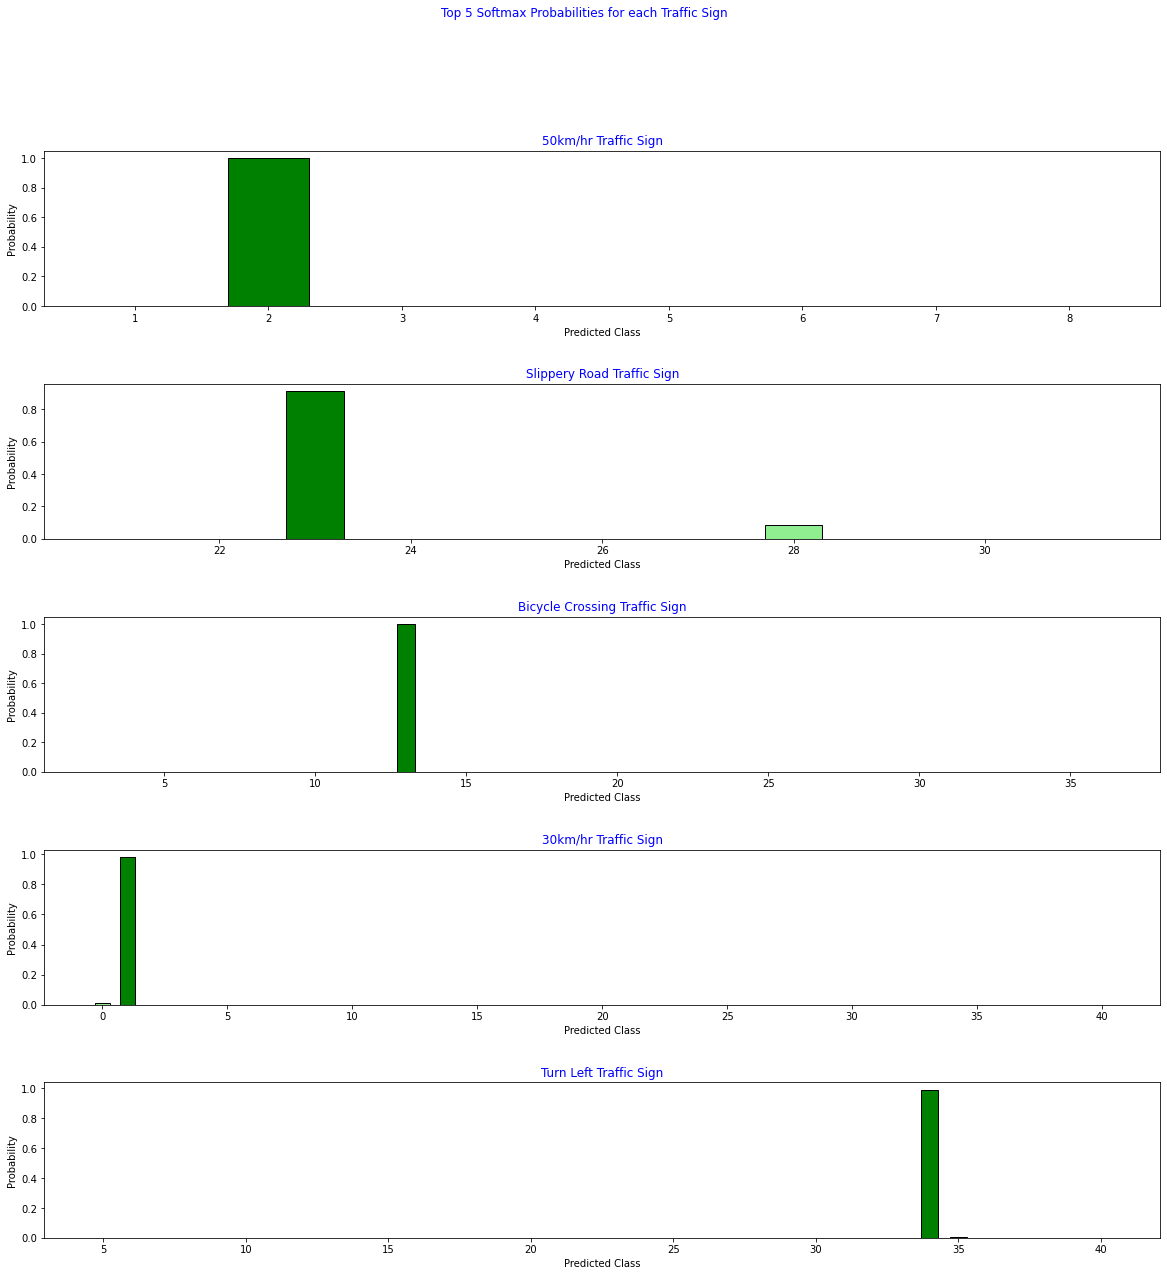

In [167]:
plt.figure(figsize=(20, 20))

plt.subplots_adjust(hspace=0.5)


plt.subplot(511)
plt.title("50km/hr Traffic Sign", color='blue')
plt.bar(classes_probabilities[0][0], classes_probabilities[0][1], width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(512)
plt.title("Slippery Road Traffic Sign", color='blue')
plt.bar(classes_probabilities[1][0], classes_probabilities[1][1], width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(513)
plt.title("Bicycle Crossing Traffic Sign", color='blue')
plt.bar(classes_probabilities[2][0], classes_probabilities[2][1], width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(514)
plt.title("30km/hr Traffic Sign", color='blue')
plt.bar(classes_probabilities[3][0], classes_probabilities[3][1], width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(515)
plt.title("Turn Left Traffic Sign", color='blue')
plt.bar(classes_probabilities[4][0], classes_probabilities[4][1], width=0.6, color=['green', 'lightgreen'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")


plt.suptitle("Top 5 Softmax Probabilities for each Traffic Sign", color='blue')
plt.show()




### Examples of incorrect classifications: Bicycle Crossing signs
Despite the high accuracy score, and the high results on the above test data notwithstanding, I noticed the model has difficult classifying bicycle crossing signs. This section illustrates this on 5 bicycle crossing traffic signs I found on the Web. 

One factor here is the number of training samples. Looking at the dataset, bicycle crossing signs are among the signs with the fewest training images: 240 for bicycle crossing compared with 1980 and 2010 respectively for 30km/hr and 50km/hr traiffic signs. So, one remedy could be to use more training samples of bicycle crossing signs.

['./data/bicycle-crossing/bicycle-crossing-3.jpg', './data/bicycle-crossing/bicycle-crossing-2.jpg', './data/bicycle-crossing/bicycle-crossing-1.jpg', './data/bicycle-crossing/bicycle-crossing-5.jpg', './data/bicycle-crossing/bicycle-crossing-4.jpg']


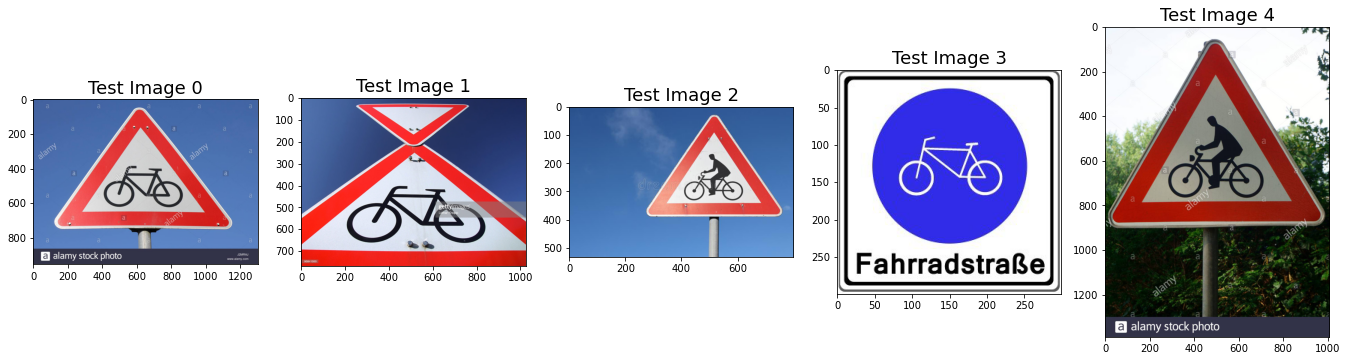

In [168]:
bicycle_crossing_files = glob.glob('./data/bicycle-crossing/*.jpg')
print(bicycle_crossing_files)

plot_5_images_side_by_side_cmap(
    mpimg.imread(bicycle_crossing_files[0]), "Test Image 0",
    mpimg.imread(bicycle_crossing_files[1]), "Test Image 1",
    mpimg.imread(bicycle_crossing_files[2]), "Test Image 2",
    mpimg.imread(bicycle_crossing_files[3]), "Test Image 3",
    mpimg.imread(bicycle_crossing_files[4]), "Test Image 4"
)

In [169]:
for i in range(len(bicycle_crossing_files)):
        img = cv2.imread(bicycle_crossing_files[i])
        
        img = np.asarray(img)
        img = cv2.resize(img, (32, 32))
        img = preprocessing(img)
        
        #Reshape reshape
        img = img.reshape(1, 32, 32, 1)

        #Test image
        predicted_class = model.predict_classes(img)
        
        label = get_label_for_class(predicted_class)
        
        print("Image {}: predicted sign = {} \t{}".format(i, str(predicted_class), label ))

Image 0: predicted sign = [30] 	Beware of ice/snow
Image 1: predicted sign = [22] 	Bumpy road
Image 2: predicted sign = [39] 	Keep left
Image 3: predicted sign = [8] 	Speed limit (120km/h)
Image 4: predicted sign = [12] 	Priority road


In [170]:
bicycle_classes_probabilities = []

for i in range(len(bicycle_crossing_files)):
    print("Traffic Sign ", i)
    classes, probabilities = top_5_softmax_probabilities(bicycle_crossing_files[i])
    
    bicycle_classes_probabilities.append([classes, probabilities])
    
    print("\n")

Traffic Sign  0
Predicted Class: Beware of ice/snow Probability: 0.5082788      
Predicted Class: Dangerous curve to the right Probability: 0.48345116     
Predicted Class: Roundabout mandatory Probability: 0.0051136273   
Predicted Class: Road narrows on the right Probability: 0.0013153707   
Predicted Class: Bicycles crossing Probability: 0.0008278907   


Traffic Sign  1
Predicted Class: Bumpy road      Probability: 0.99480814     
Predicted Class: Turn right ahead Probability: 0.0015083886   
Predicted Class: Road work       Probability: 0.0011071833   
Predicted Class: Right-of-way at the next intersection Probability: 0.000920787    
Predicted Class: Priority road   Probability: 0.0007410118   


Traffic Sign  2
Predicted Class: Keep left       Probability: 0.3983782      
Predicted Class: End of speed limit (80km/h) Probability: 0.21659425     
Predicted Class: Children crossing Probability: 0.111925974    
Predicted Class: Priority road   Probability: 0.10835338     
Predicted 

Observations:
* These results show that our model is having difficulty classifying bicycle crossing signs correctly. 
* Looking at the Top 5 softmax probabilities for each sign: in this latest run only one of the images contain bicycle crossing in their Top 5 Softmax probabilities.

The following bar chars illustrate this visually.

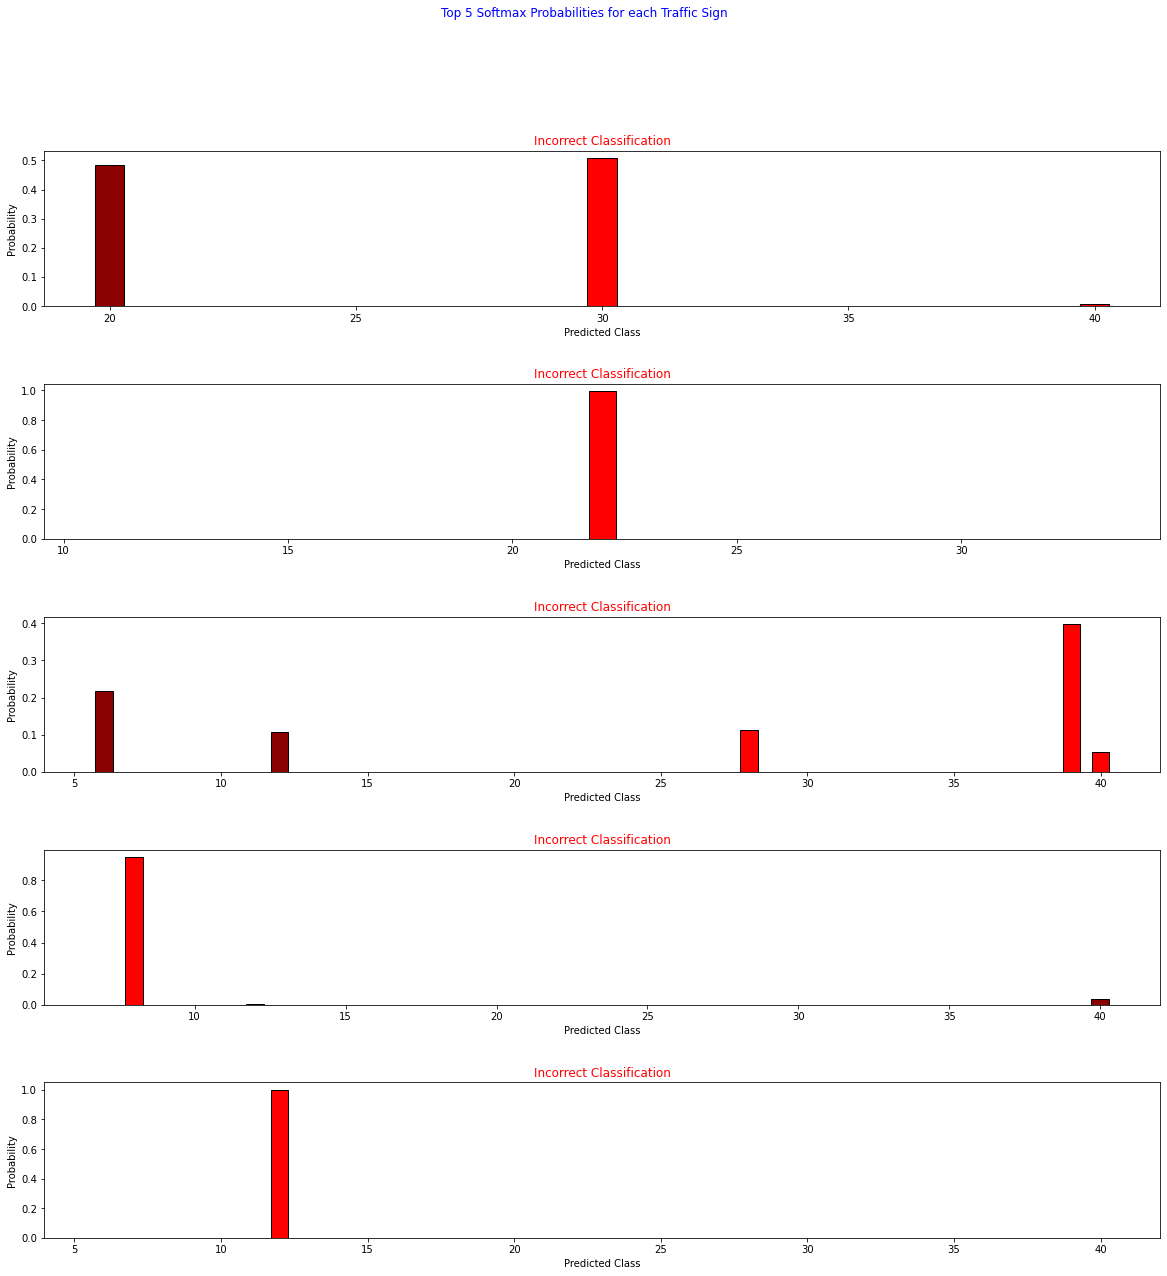

In [171]:
plt.figure(figsize=(20, 20))

plt.subplots_adjust(hspace=0.5)


plt.subplot(511)
plt.title("Incorrect Classification", color='red')
plt.bar(bicycle_classes_probabilities[0][0], bicycle_classes_probabilities[0][1], width=0.6, color=['red', 'darkred'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(512)
plt.title("Incorrect Classification", color='red')
plt.bar(bicycle_classes_probabilities[1][0], bicycle_classes_probabilities[1][1], width=0.6, color=['red', 'darkred'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(513)
plt.title("Incorrect Classification", color='red')
plt.bar(bicycle_classes_probabilities[2][0], bicycle_classes_probabilities[2][1], width=0.6, color=['red', 'darkred'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(514)
plt.title("Incorrect Classification", color='red')
plt.bar(bicycle_classes_probabilities[3][0], bicycle_classes_probabilities[3][1], width=0.6, color=['red', 'darkred'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")

plt.subplot(515)
plt.title("Incorrect Classification", color='red')
plt.bar(bicycle_classes_probabilities[4][0], bicycle_classes_probabilities[4][1], width=0.6, color=['red', 'darkred'], edgecolor='black')
plt.xlabel("Predicted Class")
plt.ylabel("Probability")


plt.suptitle("Top 5 Softmax Probabilities for each Traffic Sign", color='blue')
plt.show()

# Visualizing the CNN model
The `keras_visualizer` outputs a nice visualization of our model. Convert the next cell from markdown back to code if you want to re-run the visualization.

```python
from keras_visualizer import visualizer
visualizer(model, format='png', view=True)
```

![](./Images/graph.png)

## Visualizing intermediate activations

Intermediate activations are _“useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters”_ ([Chollet, 2018](#References)).


In [173]:
from keras.preprocessing import image
from keras import models

In [189]:
# Extract the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [190]:
# Get a list of the numpy arrays per activation
activations = activation_model.predict(img)

Look at the shape of the activation of the first convolution layer for the image input:

In [176]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 60)


This tells us that the activation of the first convolution layer for the input image is a 28 x 28 feature map with 60 channels. Let's take a look at the 12th channel of the activation of the first layer of the LeNet classifer:

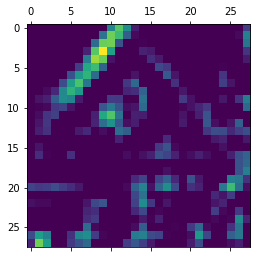

In [183]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')

And let's also look at the 21st channel:

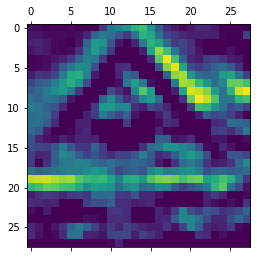

In [196]:
plt.matshow(first_layer_activation[0, :, :, 21], cmap='viridis')

## Visualizing every channel in every intermediate activation

Let's plot all the activations for this image across each layer, so we can see what's happening in every channel. [Perobon, 2018](#References) was a useful reference source for these visualizations.

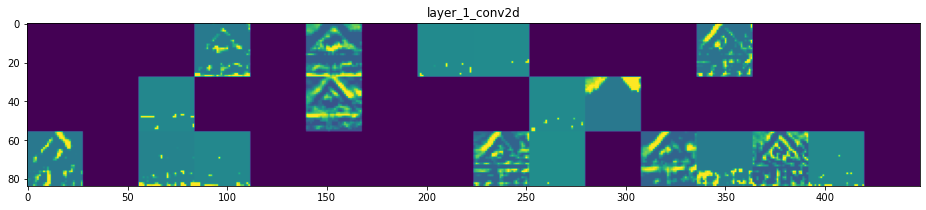

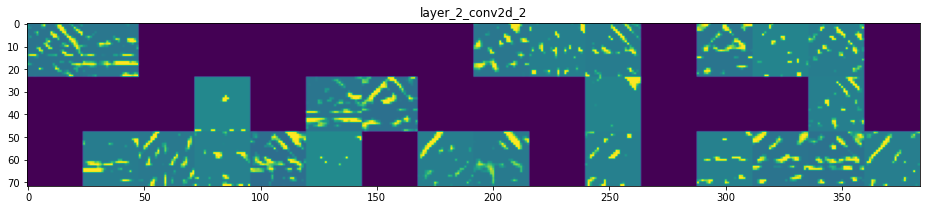

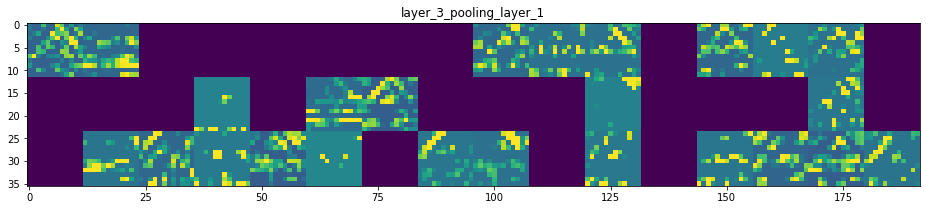

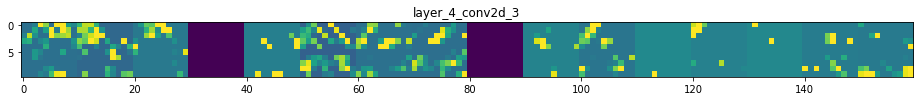

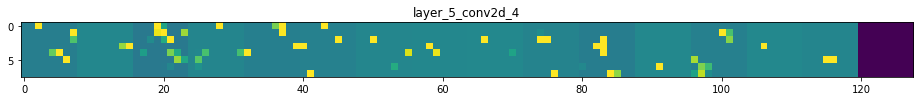

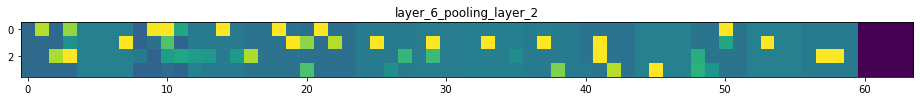

In [188]:
layer_names = []

for layer in model.layers[0:6]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols): # Tiles each filter into a big horizontal grid

        try:
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        except:
            pass
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)

    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

Some observations about the visualization:

* The first layer is arguably retaining the full shape of the traffic sign, although there are several filters that are not activated and are left blank. We can make out the basic shape of the original traffic sign image. At that stage, the activations retain almost all of the information present in the initial picture. 
* As we go deeper in the layers, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as single borders, corners and angles. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.


# References
* LeCun, Yann, Léon Bottou, Yoshua Bengio, and Patrick Haffner. ["Gradient-Based Learning Applied to Document Recognition."](http://www.academia.edu/download/61181394/Gradient_Based_Learning_Lecun20191110-2628-k1dtd1.pdf) _Proceedings of the IEEE_ 86, no. 11 (1998): 2278-324.
* Adrian Rosenbrock, 2019. [Keras ImageDataGenerator and Data Augmentation](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/) PyImageSearch.
* Francois Chollet, 2018. Deep Learning with Python, _Chapter 5: Deep Learning for Computer Vision_. Manning Publications Co. 
* TensorFlow API docs. [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
* [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)
* Sermanet, P. and LeCun, Y., 2011, July. [Traffic sign recognition with multi-scale convolutional networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). In The 2011 International Joint Conference on Neural Networks (pp. 2809-2813). IEEE.
* Papers with Code. [GTSRB (German Traffic Sign Recognition Benchmark)](https://paperswithcode.com/dataset/gtsrb).
* Stallkamp, J., Schlipsing, M., Salmen, J. and Igel, C., 2011, July. [The German traffic sign recognition benchmark: a multi-class classification competition](https://www.researchgate.net/publication/224260296_The_German_Traffic_Sign_Recognition_Benchmark_A_multi-class_classification_competition). In The 2011 international joint conference on neural networks (pp. 1453-1460). IEEE.
* Gabriel Perobon, 2018. [Visualizing intermediate activation in Convolutional Neural Networks with Keras](https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0). Published on [towardsdatascience.com](https://towardsdatascience.com/).
* Navin Krishnakumar, 2019. [Deep Learning — German Traffic Sign dataset with Keras](https://towardsdatascience.com/my-tryst-with-deep-learning-german-traffic-data-set-with-keras-87970dfb18b7).
* Stanford. [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/).
* Ian Goodfellow, Yoshua Bengio, Aaron Courville. 2016. [Deep Learning](https://www.deeplearningbook.org/). MIT Press.
* Michael Nielsen, 2019. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/).